# Multi-Objective Capacitated VRP (MOVRP) Problem Using Multi-Objective Evolutionary Algorithms (MOEAs)

### Global Functions

In [28]:
import math
import numpy as np

def parse_vrp_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Strip whitespace and filter empty lines
    lines = [line.strip() for line in lines if line.strip()]

    # Parse metadata
    metadata = {}
    i = 0
    while not lines[i].startswith('NODE_COORD_SECTION'):
        if ':' in lines[i]:
            key, value = lines[i].split(':', 1)
            metadata[key.strip()] = value.strip().strip('"')
        i += 1

    # Parse node coordinates (1-based in file, but we'll make 0-based list)
    coords = []
    i += 1  # Skip section header
    while not lines[i].startswith('DEMAND_SECTION'):
        parts = lines[i].split()
        if len(parts) == 3:
            node_id = int(parts[0]) - 1  # Make 0-based
            x, y = int(parts[1]), int(parts[2])
            # Insert at correct index in case not sequential (though they usually are)
            while len(coords) <= node_id:
                coords.append(None)
            coords[node_id] = (x, y)
        i += 1

    # Parse demands (0-based list)
    demands = []
    i += 1  # Skip section header
    while not lines[i].startswith('DEPOT_SECTION'):
        parts = lines[i].split()
        if len(parts) == 2:
            node_id = int(parts[0]) - 1  # Make 0-based
            demand = int(parts[1])
            while len(demands) <= node_id:
                demands.append(None)
            demands[node_id] = demand
        i += 1

    # Parse depot(s) — usually just one, 1-based
    depots = []
    i += 1  # Skip section header
    while i < len(lines) and lines[i] != 'EOF':
        depot = int(lines[i])
        if depot == -1:
            break
        depots.append(depot - 1)  # Make 0-based
        i += 1

    # Compute distance matrix (Euclidean 2D)
    dimension = int(metadata.get('DIMENSION', len(coords)))
    dist_matrix = np.zeros((dimension, dimension))
    for a in range(dimension):
        for b in range(dimension):
            x1, y1 = coords[a]
            x2, y2 = coords[b]
            dist_matrix[a][b] = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    return {
        'metadata': metadata,
        'coords': coords,  # List of (x, y) tuples, 0-based (index 0 = node 1)
        'demands': demands,  # List of integers, 0-based
        'depots': depots,  # List of 0-based indices (usually [0] for depot at node 1)
        'dist_matrix': dist_matrix  # Numpy array of floats
    }

## NSGA-II Implementation

In [29]:
# --- NSGA-II Implementation (cleaned) ---
import numpy as np
import random
import time

class NSGAII:
    def __init__(self, data, pop_size=20, generations=10, crossover_rate=0.7, mutation_rate=0.2):
        self.data = data
        self.pop_size = pop_size
        self.generations = generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.population = []

        # Pre-compute frequently accessed values
        self.dist_matrix = self.data['dist_matrix']
        self.capacity = int(self.data['metadata']['CAPACITY'])
        self.demands = self.data['demands']
        self.n_customers = len(self.data['coords']) - 1
        self.customer_range = list(range(1, self.n_customers + 1))

    def split_routes(self, customer_sequence):
        """Route splitting with capacity constraints"""
        routes, route, load = [], [0], 0
        for customer in customer_sequence:
            demand = self.demands[customer]
            if load + demand > self.capacity:
                route.append(0)
                routes.append(route)
                route, load = [0, customer], demand
            else:
                route.append(customer)
                load += demand
        route.append(0)
        routes.append(route)
        return routes

    def calculate_route_distance(self, route):
        """Calculate distance for a single route"""
        return sum(self.dist_matrix[route[i], route[i+1]] for i in range(len(route) - 1))

    def evaluate_individual(self, individual):
        """Assignment-compliant: Total Distance vs Standard Deviation"""
        if individual['objectives'] is not None:
            return
        routes = individual['routes']
        route_distances = [self.calculate_route_distance(route) for route in routes]
        total_dist = sum(route_distances)
        if len(route_distances) > 1:
            mean_length = total_dist / len(route_distances)
            variance = sum((d - mean_length)**2 for d in route_distances) / len(route_distances)
            route_balance = variance**0.5  # Standard deviation
        else:
            route_balance = 0.0
        individual['objectives'] = [total_dist, route_balance]

    def evaluate_population(self, population):
        for individual in population:
            self.evaluate_individual(individual)

    def generate_initial_population(self):
        population = []
        # Add 2 heuristic solutions for better starting points
        if self.pop_size >= 2:
            nn_seq = self.nearest_neighbor_solution()
            population.append(self.create_individual(nn_seq))
            bal_seq = self.balanced_insertion_solution()
            population.append(self.create_individual(bal_seq))
            for _ in range(self.pop_size - 2):
                perm = self.customer_range[:]
                random.shuffle(perm)
                population.append(self.create_individual(perm))
        else:
            for _ in range(self.pop_size):
                perm = self.customer_range[:]
                random.shuffle(perm)
                population.append(self.create_individual(perm))
        return population

    def nearest_neighbor_solution(self):
        """Distance-optimized solution"""
        unvisited = set(self.customer_range)
        solution = []
        current = 0
        while unvisited:
            distances = [(self.dist_matrix[current, customer], customer)
                        for customer in unvisited]
            _, next_customer = min(distances)
            solution.append(next_customer)
            unvisited.remove(next_customer)
            current = next_customer
        return solution

    def balanced_insertion_solution(self):
        """Balance-focused solution"""
        customers_by_distance = [(self.dist_matrix[0, c], c) for c in self.customer_range]
        customers_by_distance.sort()
        solution = []
        near = [c for _, c in customers_by_distance[:len(customers_by_distance)//2]]
        far = [c for _, c in customers_by_distance[len(customers_by_distance)//2:]]
        for i in range(max(len(near), len(far))):
            if i < len(near):
                solution.append(near[i])
            if i < len(far):
                solution.append(far[i])
        return solution

    def fast_non_dominated_sort(self, population):
        """Non-dominated sorting"""
        n = len(population)
        objectives = [ind['objectives'] for ind in population]
        domination_count = [0] * n
        dominated_solutions = [[] for _ in range(n)]
        for i in range(n):
            obj1_i, obj2_i = objectives[i]
            for j in range(i + 1, n):
                obj1_j, obj2_j = objectives[j]
                if (obj1_i <= obj1_j and obj2_i <= obj2_j) and (obj1_i < obj1_j or obj2_i < obj2_j):
                    dominated_solutions[i].append(j)
                    domination_count[j] += 1
                elif (obj1_j <= obj1_i and obj2_j <= obj2_i) and (obj1_j < obj1_i or obj2_j < obj2_i):
                    dominated_solutions[j].append(i)
                    domination_count[i] += 1
        current_front = [i for i in range(n) if domination_count[i] == 0]
        rank = 1
        for i in current_front:
            population[i]['rank'] = rank
        while current_front:
            next_front = []
            for i in current_front:
                for j in dominated_solutions[i]:
                    domination_count[j] -= 1
                    if domination_count[j] == 0:
                        next_front.append(j)
            if next_front:
                rank += 1
                for i in next_front:
                    population[i]['rank'] = rank
            current_front = next_front

    def calculate_crowding_distance(self, population):
        """Calculate crowding distance"""
        for ind in population:
            ind['crowding_distance'] = 0.0
        rank_groups = {}
        for i, ind in enumerate(population):
            rank = ind['rank']
            if rank not in rank_groups:
                rank_groups[rank] = []
            rank_groups[rank].append(i)
        for indices in rank_groups.values():
            n_front = len(indices)
            if n_front <= 2:
                for i in indices:
                    population[i]['crowding_distance'] = float('inf')
                continue
            for obj_idx in range(2):
                indices.sort(key=lambda i: population[i]['objectives'][obj_idx])
                population[indices[0]]['crowding_distance'] = float('inf')
                population[indices[-1]]['crowding_distance'] = float('inf')
                obj_range = population[indices[-1]]['objectives'][obj_idx] - population[indices[0]]['objectives'][obj_idx]
                if obj_range > 0:
                    for j in range(1, n_front - 1):
                        i = indices[j]
                        if population[i]['crowding_distance'] != float('inf'):
                            prev_obj = population[indices[j-1]]['objectives'][obj_idx]
                            next_obj = population[indices[j+1]]['objectives'][obj_idx]
                            population[i]['crowding_distance'] += (next_obj - prev_obj) / obj_range

    def tournament_selection(self, population, tournament_size=2):
        """Tournament selection"""
        tournament = random.sample(population, tournament_size)
        return min(tournament, key=lambda x: (x['rank'], -x['crowding_distance']))

    def create_individual(self, customer_sequence):
        """Create individual from sequence"""
        return {
            'customer_sequence': customer_sequence,
            'routes': self.split_routes(customer_sequence),
            'objectives': None,
            'rank': None,
            'crowding_distance': 0.0
        }

    def pmx_crossover(self, parent1, parent2):
        """PMX crossover"""
        size = len(parent1['customer_sequence'])
        p1, p2 = parent1['customer_sequence'], parent2['customer_sequence']
        if size < 2:
            return self.create_individual(p1[:])
        start, end = sorted(random.sample(range(size), 2))
        child = [None] * size
        for i in range(start, end + 1):
            child[i] = p1[i]
        mapping = {p2[i]: p1[i] for i in range(start, end + 1) if p1[i] != p2[i]}
        for i in range(size):
            if child[i] is None:
                gene = p2[i]
                while gene in mapping:
                    gene = mapping[gene]
                if gene in child:
                    available = set(self.customer_range) - set(g for g in child if g is not None)
                    gene = available.pop() if available else p2[i]
                child[i] = gene
        return self.create_individual(child)

    def swap_mutation(self, individual):
        seq = individual['customer_sequence'][:]
        if random.random() < self.mutation_rate:
            mutation_type = random.choice(['swap', 'insert', 'reverse'])
            if mutation_type == 'swap' and len(seq) > 1:
                i, j = random.sample(range(len(seq)), 2)
                seq[i], seq[j] = seq[j], seq[i]
            elif mutation_type == 'insert' and len(seq) > 2:
                i = random.randint(0, len(seq)-1)
                j = random.randint(0, len(seq)-1)
                if i != j:
                    gene = seq.pop(i)
                    seq.insert(j, gene)
            elif mutation_type == 'reverse' and len(seq) > 2:
                i, j = sorted(random.sample(range(len(seq)), 2))
                seq[i:j+1] = reversed(seq[i:j+1])
        return self.create_individual(seq)

    def run(self):
        """Main NSGA-II algorithm"""
        self.population = self.generate_initial_population()
        self.evaluate_population(self.population)
        self.fast_non_dominated_sort(self.population)
        self.calculate_crowding_distance(self.population)
        for gen in range(1, self.generations + 1):
            offspring = []
            for _ in range(self.pop_size):
                parent1 = self.tournament_selection(self.population)
                parent2 = self.tournament_selection(self.population)
                if random.random() < self.crossover_rate:
                    child = self.pmx_crossover(parent1, parent2)
                else:
                    child = self.create_individual(parent1['customer_sequence'][:])
                child = self.swap_mutation(child)
                offspring.append(child)
            self.evaluate_population(offspring)
            combined = self.population + offspring
            self.fast_non_dominated_sort(combined)
            self.calculate_crowding_distance(combined)
            combined.sort(key=lambda x: (x['rank'], -x['crowding_distance']))
            self.population = combined[:self.pop_size]
        return self.population

## SPEA2 Implementation

# Experiment

NSGA-II EXPERIMENT - Assignment 2

Algorithm: NSGAII, Parameter Set: Conservative
  Small1... ✓ 115/1200 Pareto solutions
  Small2... ✓ 111/1200 Pareto solutions
  Medium1... ✓ 137/1200 Pareto solutions
  Medium2... ✓ 121/1200 Pareto solutions
  Large1... ✓ 69/1200 Pareto solutions
  Large2... ✓ 92/1200 Pareto solutions

Algorithm: NSGAII, Parameter Set: Balanced
  Small1... ✓ 69/800 Pareto solutions
  Small2... ✓ 60/800 Pareto solutions
  Medium1... ✓ 95/800 Pareto solutions
  Medium2... ✓ 79/800 Pareto solutions
  Large1... ✓ 75/800 Pareto solutions
  Large2... ✓ 50/800 Pareto solutions

Algorithm: NSGAII, Parameter Set: Aggressive
  Small1... ✓ 53/500 Pareto solutions
  Small2... ✓ 34/500 Pareto solutions
  Medium1... ✓ 45/500 Pareto solutions
  Medium2... ✓ 46/500 Pareto solutions
  Large1... ✓ 38/500 Pareto solutions
  Large2... ✓ 56/500 Pareto solutions

Algorithm Instance Parameter    PF/Total   Distance  Balance  Convergence  Diversity  Time  
----------------------------------

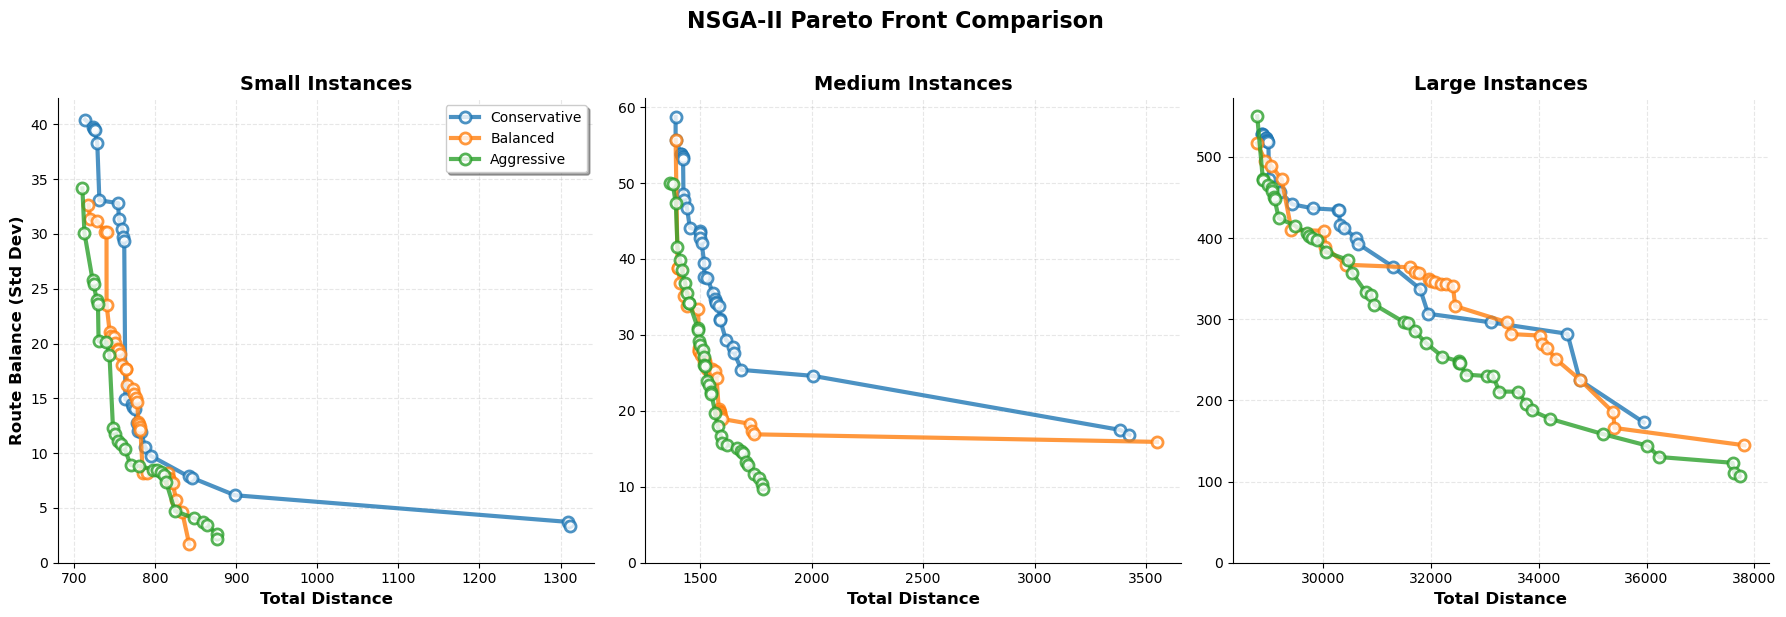

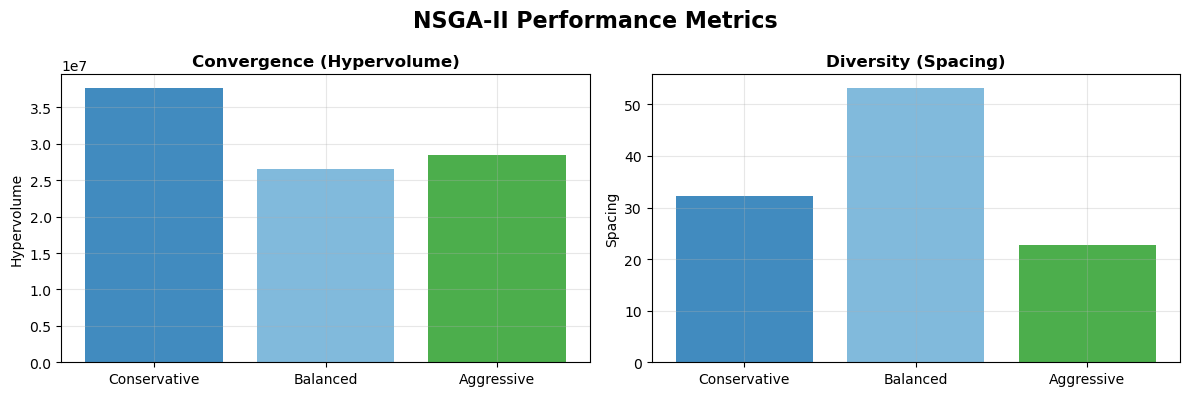


✓ Results saved to nsga2_results.csv


In [ ]:
# --- Experiment Cell with matplotlib cubic interpolation ---
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
import numpy as np


def calculate_metrics(pareto_front):
    """Calculate convergence and diversity metrics"""
    if not pareto_front or len(pareto_front) < 2:
        return 0, 0
    obj1 = [ind['objectives'][0] for ind in pareto_front]
    obj2 = [ind['objectives'][1] for ind in pareto_front]
    # Convergence: Hypervolume
    ref_point = [max(obj1) * 1.1, max(obj2) * 1.1]
    convergence = sum((ref_point[0] - o1) * (ref_point[1] - o2) for o1, o2 in zip(obj1, obj2))
    # Diversity: Spacing
    if len(pareto_front) < 3:
        diversity = 0
    else:
        distances = []
        for i, ind1 in enumerate(pareto_front):
            min_dist = min(((ind1['objectives'][0] - ind2['objectives'][0])**2 +
                           (ind1['objectives'][1] - ind2['objectives'][1])**2)**0.5
                          for j, ind2 in enumerate(pareto_front) if i != j)
            distances.append(min_dist)
        diversity = np.std(distances)
    return convergence, diversity

def run_focused_experiment(moea_classes, instance_files, param_sets, num_runs=5):
    """Complete NSGA-II experiment with all solutions tracking"""
    print("NSGA-II EXPERIMENT - Assignment 2")
    print("=" * 50)
    results = []
    pareto_fronts = {}
    all_solutions_dict = {}
    data_cache = {}
    for algo_name, algo_class in moea_classes:
        for params in param_sets:
            param_name = params["name"]
            print(f"\nAlgorithm: {algo_name}, Parameter Set: {param_name}")
            for inst_name, inst_file in instance_files:
                print(f"  {inst_name}...", end=" ")
                if inst_file not in data_cache:
                    data_cache[inst_file] = parse_vrp_file(inst_file)
                data = data_cache[inst_file]
                all_run_solutions = []
                run_times = []
                for run in range(1, num_runs + 1):
                    try:
                        random.seed(run * 456)
                        np.random.seed(run * 456)
                        nsga = algo_class(
                            data=data,
                            pop_size=params['pop_size'],
                            generations=params['generations'],
                            crossover_rate=params['crossover_rate'],
                            mutation_rate=params['mutation_rate']
                        )
                        start_time = time.time()
                        final_pop = nsga.run()
                        run_times.append(time.time() - start_time)
                        all_run_solutions.extend(final_pop)
                    except Exception as e:
                        print(f"Error: {e}")
                        continue
                if all_run_solutions:
                    temp_nsga = NSGAII(data=data, pop_size=10, generations=1)
                    temp_nsga.fast_non_dominated_sort(all_run_solutions)
                    pareto_front = [sol for sol in all_run_solutions if sol.get('rank') == 1]
                    pareto_front.sort(key=lambda x: x['objectives'][0])
                    key = f"{inst_name}_{param_name}_{algo_name}"
                    pareto_fronts[key] = pareto_front
                    all_solutions_dict[key] = all_run_solutions
                    convergence, diversity = calculate_metrics(pareto_front)
                    results.append({
                        'Algorithm': algo_name,
                        'Instance': inst_name,
                        'Parameter': param_name,
                        'Front_Size': len(pareto_front),
                        'Total_Solutions': len(all_run_solutions),
                        'Best_Distance': min(ind['objectives'][0] for ind in pareto_front),
                        'Best_Balance': min(ind['objectives'][1] for ind in pareto_front),
                        'Convergence': convergence,
                        'Diversity': diversity,
                        'Time': np.mean(run_times),
                        'Evaluations': params['pop_size'] * params['generations']
                    })
                    print(f"✓ {len(pareto_front)}/{len(all_run_solutions)} Pareto solutions")
                else:
                    print("✗ Failed")
    display_results(results)
    plot_pareto_fronts(pareto_fronts)
    plot_metrics(pareto_fronts)
    pd.DataFrame(results).to_csv('nsga2_results.csv', index=False)
    print("\n✓ Results saved to nsga2_results.csv")
    return results, pareto_fronts, all_solutions_dict

def display_results(results):
    print(f"\n{'Algorithm':<8} {'Instance':<8} {'Parameter':<12} {'PF/Total':<10} {'Distance':<9} {'Balance':<8} {'Convergence':<12} {'Diversity':<10} {'Time':<6}")
    print("-" * 100)
    for r in results:
        div_str = f"{r['Diversity']:.3f}" if r['Diversity'] > 0 else "N/A"
        pf_ratio = f"{r['Front_Size']}/{r['Total_Solutions']}"
        print(f"{r['Algorithm']:<8} {r['Instance']:<8} {r['Parameter']:<12} {pf_ratio:<10} "
              f"{r['Best_Distance']:<9.1f} {r['Best_Balance']:<8.2f} "
              f"{r['Convergence']:<12.0f} {div_str:<10} {r['Time']:<6.1f}")

def plot_pareto_fronts(pareto_fronts):
    """Clean Pareto front visualization without scipy dependency"""
    colors = {'Conservative': '#1f77b4', 'Balanced': '#ff7f0e', 'Aggressive': '#2ca02c'}
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    groups = ['Small', 'Medium', 'Large']
    
    for idx, group in enumerate(groups):
        ax = axes[idx]
        
        for param in ['Conservative', 'Balanced', 'Aggressive']:
            # Collect all points for this parameter and group
            points = []
            for key, front in pareto_fronts.items():
                if front and group in key and param in key:
                    points.extend([(ind['objectives'][0], ind['objectives'][1]) for ind in front])
            
            if len(points) < 3:
                continue
                
            # Remove duplicates and sort
            points = sorted(set(points))
            
            # Filter to keep only Pareto optimal points
            pareto_points = []
            for i, (x1, y1) in enumerate(points):
                # Check if this point is dominated by any other point
                dominated = any(x2 <= x1 and y2 <= y1 and (x2 < x1 or y2 < y1) 
                              for j, (x2, y2) in enumerate(points) if i != j)
                if not dominated:
                    pareto_points.append((x1, y1))
            
            # Sort Pareto points by first objective
            pareto_points.sort()
            
            if len(pareto_points) >= 2:
                x_vals = [p[0] for p in pareto_points]
                y_vals = [p[1] for p in pareto_points]
                
                # Plot with distinctive style
                ax.plot(x_vals, y_vals, 'o-', color=colors[param], 
                       linewidth=3, markersize=8, alpha=0.8, label=param,
                       markerfacecolor='white', markeredgewidth=2, 
                       markeredgecolor=colors[param])
        
        # Styling
        ax.set_xlabel("Total Distance", fontweight='bold', fontsize=12)
        ax.set_ylabel("Route Balance (Std Dev)" if idx == 0 else "", fontweight='bold', fontsize=12)
        ax.set_title(f"{group} Instances", fontweight='bold', fontsize=14)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_ylim(bottom=0)
        
        # Add legend only to first plot
        if idx == 0:
            ax.legend(frameon=True, fancybox=True, shadow=True, loc='upper right')
        
        # Clean up spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    plt.suptitle("NSGA-II Pareto Front Comparison", fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

def plot_metrics(pareto_fronts):
    metrics = {}
    for key, front in pareto_fronts.items():
        if front:
            parts = key.split('_')
            param = parts[1] if len(parts) > 1 else 'Unknown'
            if param not in metrics:
                metrics[param] = {'conv': [], 'div': []}
            conv, div = calculate_metrics(front)
            metrics[param]['conv'].append(conv)
            metrics[param]['div'].append(div if div > 0 else 0)
    if not metrics:
        return
    params = list(metrics.keys())
    avg_conv = [np.mean(metrics[p]['conv']) for p in params]
    avg_div  = [np.mean(metrics[p]['div'])  for p in params]
    palette = {
        'Conservative': '#1f77b4',
        'Balanced':     '#ff7f0e',  # Changed from '#6baed6' to match Pareto front plot
        'Aggressive':   '#2ca02c'
    }
    colors = [palette.get(p, '#888888') for p in params]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.bar(params, avg_conv, color=colors, alpha=0.85)
    ax1.set_title("Convergence (Hypervolume)", fontweight='bold')
    ax1.set_ylabel("Hypervolume")
    ax1.grid(True, alpha=0.3)
    ax2.bar(params, avg_div, color=colors, alpha=0.85)
    ax2.set_title("Diversity (Spacing)", fontweight='bold')
    ax2.set_ylabel("Spacing")
    ax2.grid(True, alpha=0.3)
    plt.suptitle("NSGA-II Performance Metrics", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# --- Configuration and execution ---
moea_classes = [("NSGAII", NSGAII)]
instance_files = [
    ("Small1", "data/small.vrp"),
    ("Small2", "data/small2.vrp"),
    ("Medium1", "data/medium.vrp"),
    ("Medium2", "data/medium2.vrp"),
    ("Large1", "data/large.vrp"),
    ("Large2", "data/large2.vrp")
]
param_sets = [
    {"name": "Conservative", "pop_size": 60, "generations": 25, "crossover_rate": 0.5, "mutation_rate": 0.05},
    {"name": "Balanced", "pop_size": 40, "generations": 40, "crossover_rate": 0.8, "mutation_rate": 0.2},
    {"name": "Aggressive", "pop_size": 25, "generations": 80, "crossover_rate": 0.95, "mutation_rate": 0.5}
]
results, pareto_fronts, all_solutions = run_focused_experiment(
    moea_classes, instance_files, param_sets, num_runs=20
)